In [116]:
# Some classifiers from Scikit-learn:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

# LightGBM, Catboost and XGBoost:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import pandas as pd
import numpy as np

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# from missingpy import MissForest

from capstone_functions import *

In [117]:
# Load data:
df = look_n_load("edstays2.csv")
df.disposition.value_counts()


Shape: (428284, 18)

Columns: ['Unnamed: 0', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition', 'admitted', 'difftime', 'nights', 'hours', 'discharge_hour', 'admission_hour', 'admission_date', 'admission_day']

Missing proportions:
 Unnamed: 0           0.000000
subject_id           0.000000
hadm_id              0.510857
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
admitted             0.000000
difftime             0.000000
nights               0.000000
hours                0.000000
discharge_hour       0.000000
admission_hour       0.000000
admission_date       0.000000
admission_day        0.000000
dtype: float64

Data:
    Unnamed: 0  subject_id     hadm_id   stay_id               intime  \
0           0    10000032  22595853.0  33258284  2180-06-05 19:17:00   

HOME        254545
ADMITTED    166303
TRANSFER      7436
Name: disposition, dtype: int64

In [118]:
triage = look_n_load('IN/triage.csv')


Shape: (447712, 11)

Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
temperature       0.054935
heartrate         0.040111
resprate          0.047743
o2sat             0.048355
sbp               0.042941
dbp               0.044823
pain              0.030415
acuity            0.016368
chiefcomplaint    0.000051
dtype: float64

Data:
    subject_id   stay_id  temperature  heartrate  resprate  o2sat    sbp   dbp  \
0    10000032  32952584         97.8       87.0      14.0   97.0   71.0  43.0   
1    10000032  33258284         98.4       70.0      16.0   97.0  106.0  63.0   
2    10000032  35968195         99.4      105.0      18.0   96.0  106.0  57.0   
3    10000032  38112554         98.9       88.0      18.0   97.0  116.0  88.0   
4    10000032  39399961         98.7       77.0      16.0   98.0   96.0  50.0   

  pain  acuity

In [119]:
# subject_df = pd.DataFrame()
# df_sub = df2[['subject_id', 'stay_id', 'intime']]
# subject_ids = list(set(df_sub.subject_id))
# for subject_id in subject_ids:
#     df_sub_sub = df_sub[df_sub.subject_id==subject_id].sort_values('intime').reset_index(drop=True)
#     df_sub_sub['stay'] = df_sub_sub.index
#     subject_df = subject_df.append(df_sub_sub)
# subject_df

In [120]:
# df2_stays = pd.merge(df2, subject_df, on =['subject_id','stay_id'], how='left')
# df2_stays

In [121]:
# how full is the hospital
capacity = df[df['disposition'].isin(['ADMITTED'])].admission_date.value_counts().reset_index()
capacity.columns = ['admission_date', 'capacity']
capacity
df2 = pd.merge(df, capacity, on='admission_date', how='left')
df2.capacity = df2.capacity.fillna(0)

# work hours
# 8-6
def work_hours(x):
    if x >= 8 and x <= 18:
        return 1 
    else:
        return 0
    
df2['work_hours'] = df2.admission_hour.apply(work_hours)

# return visits
df2 = df2.sort_values('intime')
visit_counts = df2[['subject_id']].groupby('subject_id').cumcount()
df2['visits'] = visit_counts
df2.sort_values(['subject_id', 'intime'])

# create length of stay logic/target variable
def length_of_stay(x):
    if x == 0:
        return 'Within the Day'
    elif x <= 7:
        return 'Within the Week'
    elif x <= 28:
        return 'Within the Month'
    else:
        return 'Beyond a Month'
    
df2['length_of_stay'] = df2.nights.apply(length_of_stay)
print(df2['length_of_stay'].value_counts())

# get chief complaint and hi risk tokens (determine high risk tokens for each)
df2 = pd.merge(df2, triage, on=['subject_id','stay_id'], how='left')
df2

# fix pain scale

def rescale_pain(x):
    try:
        x = int(x)
        if x > 100:
            return 10
        elif x > 10:
            return x/10
        elif x < 0:
            return 0
        else:
            return x
    except:
        return None
    
df2['pain'] = [rescale_pain(x) for x in df2.pain]


Within the Day      365699
Beyond a Month       43123
Within the Week      15273
Within the Month      4189
Name: length_of_stay, dtype: int64


In [122]:
df2.pain.value_counts()

0.0     142743
8.0      41853
10.0     40897
7.0      31660
5.0      29592
6.0      25397
9.0      20295
4.0      20020
3.0      16390
2.0      14196
1.3      11142
1.0       6039
1.2         68
1.1         64
1.5         29
1.8          7
1.9          6
9.8          4
1.6          3
8.8          3
2.5          3
2.2          2
1.4          2
9.5          2
5.4          2
7.5          1
2.1          1
4.5          1
5.1          1
6.7          1
3.1          1
6.9          1
7.3          1
6.1          1
9.6          1
4.6          1
5.6          1
9.7          1
6.8          1
2.3          1
Name: pain, dtype: int64

In [136]:
# then grab all keep_cols
keep_cols = [
    'admission_hour',
    'capacity',
    'gender',
    'arrival_transport',
    'race',
    'visits',
    'temperature',
    'heartrate',
    'resprate',
    'o2sat',
    'sbp', 'dbp',
    'pain', 'acuity'
]

target_col = 'admitted' # out of [admitted, length_of_stay]
keep_cols.append(target_col)

if target_col == 'length_of_stay':
    df2_filt = df2[df2.admitted==1]
    df2_sub = df2_filt[keep_cols]
else:
    df2_sub = df2[keep_cols]


# # Convert categories to dummies:
df2_sub['arrival_transport'] = pd.Categorical(df2_sub.arrival_transport)
df2_sub['gender'] = pd.Categorical(df2_sub.gender)
df2_sub['race'] = pd.Categorical(df2_sub.race)
df2_sub[target_col] = pd.Categorical(df2_sub[target_col])

df2_sub = df2_sub.dropna() # model with complete data

df2_sub[target_col].value_counts()

df2_sub.dtypes

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

admission_hour          int64
capacity              float64
gender               category
arrival_transport    category
race                 category
visits                  int64
temperature           float64
heartrate             float64
resprate              float64
o2sat                 float64
sbp                   float64
dbp                   float64
pain                  float64
acuity                float64
admitted             category
dtype: object

In [142]:


# Prepare data:
X = df2_sub.drop(labels=[target_col], axis=1)
X = pd.get_dummies(X)
Y = df2_sub[target_col]

print(X.dtypes)
# Standardize 0-1 for features:

# scaler_01 = MinMaxScaler()
# scaler_01.fit(X)
# X_scaler = scaler_01.transform(X)

# Initiative estimators:
ran = RandomForestClassifier()
gbm = LGBMClassifier()
log = LogisticRegression()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier()
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
bag = BaggingClassifier()
nnn = MLPClassifier()
cat = CatBoostClassifier()

# List of classifiers:
models = [
    ran,
    gbm,
    log,
#     gbc,
#     xgb,
#     ext,
#     ada,
#     gnb,
#     bag,
#     nnn
#     cat
]

# Train all classifiers by using for loop:

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=4, random_state=42)

acc_mean = []
acc_sd = []
recall_mean = []
recall_sd = []
auc_mean = []
auc_sd = []

for mod in models:
    print(mod)
    acc = cross_val_score(mod, X, Y, scoring="accuracy", cv=cv, n_jobs=-1, verbose=False)
    rec = cross_val_score(mod, X, Y, scoring="recall", cv=cv, n_jobs=-1, verbose=False)
    auc = cross_val_score(mod, X, Y, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=False)
    # Recall metric:
    acc_mean.append(acc.mean())
    acc_sd.append(np.std(acc))
    # Recall metric:
    recall_mean.append(rec.mean())
    recall_sd.append(np.std(rec))
    # AUC metric:
    auc_mean.append(auc.mean())
    auc_sd.append(np.std(auc))

df_results = pd.DataFrame({"Classifier": [j.__class__.__name__ for j in models],
                           "Acc_mean": acc_mean,
                           "Acc_sd": acc_sd,
                           "Recall_mean": recall_mean,
                           "Recall_sd": recall_sd,
                           "AUC_mean": auc_mean,
                           "AUC_sd": auc_sd})



admission_hour                                      int64
capacity                                          float64
visits                                              int64
temperature                                       float64
heartrate                                         float64
resprate                                          float64
o2sat                                             float64
sbp                                               float64
dbp                                               float64
pain                                              float64
acuity                                            float64
gender_F                                            uint8
gender_M                                            uint8
arrival_transport_AMBULANCE                         uint8
arrival_transport_HELICOPTER                        uint8
arrival_transport_OTHER                             uint8
arrival_transport_UNKNOWN                           uint8
arrival_transp

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 wh

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 wh

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 wh

In [143]:
# Report results:
print(df_results)

               Classifier  Acc_mean    Acc_sd  Recall_mean  Recall_sd  \
0  RandomForestClassifier       NaN       NaN          NaN        NaN   
1          LGBMClassifier  0.736215  0.001322     0.576624   0.002517   
2      LogisticRegression  0.713153  0.001695     0.507081   0.006388   

   AUC_mean    AUC_sd  
0       NaN       NaN  
1  0.801632  0.001284  
2  0.769155  0.001793  


In [114]:
df_results.to_csv(f'Model_Results_{target_col}_Sep19.csv')

In [144]:
ran.fit(X,Y)

RandomForestClassifier()

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/das/anaconda3/envs/gdal_env/l

/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/das/anaconda3/envs/gdal_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

<BarContainer object of 51 artists>

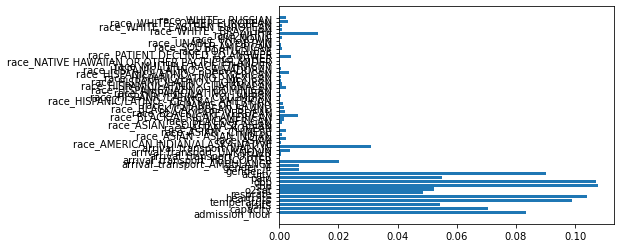

In [148]:
import matplotlib.pyplot as plt

plt.barh(X.columns, ran.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

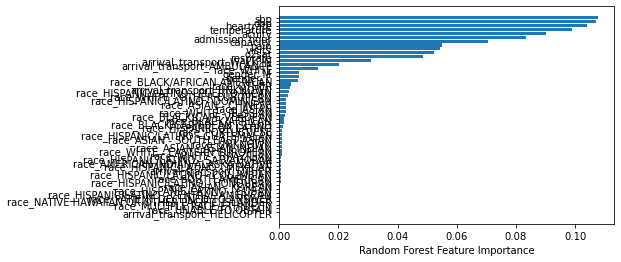

Text(0.5, 0, 'Random Forest Feature Importance')

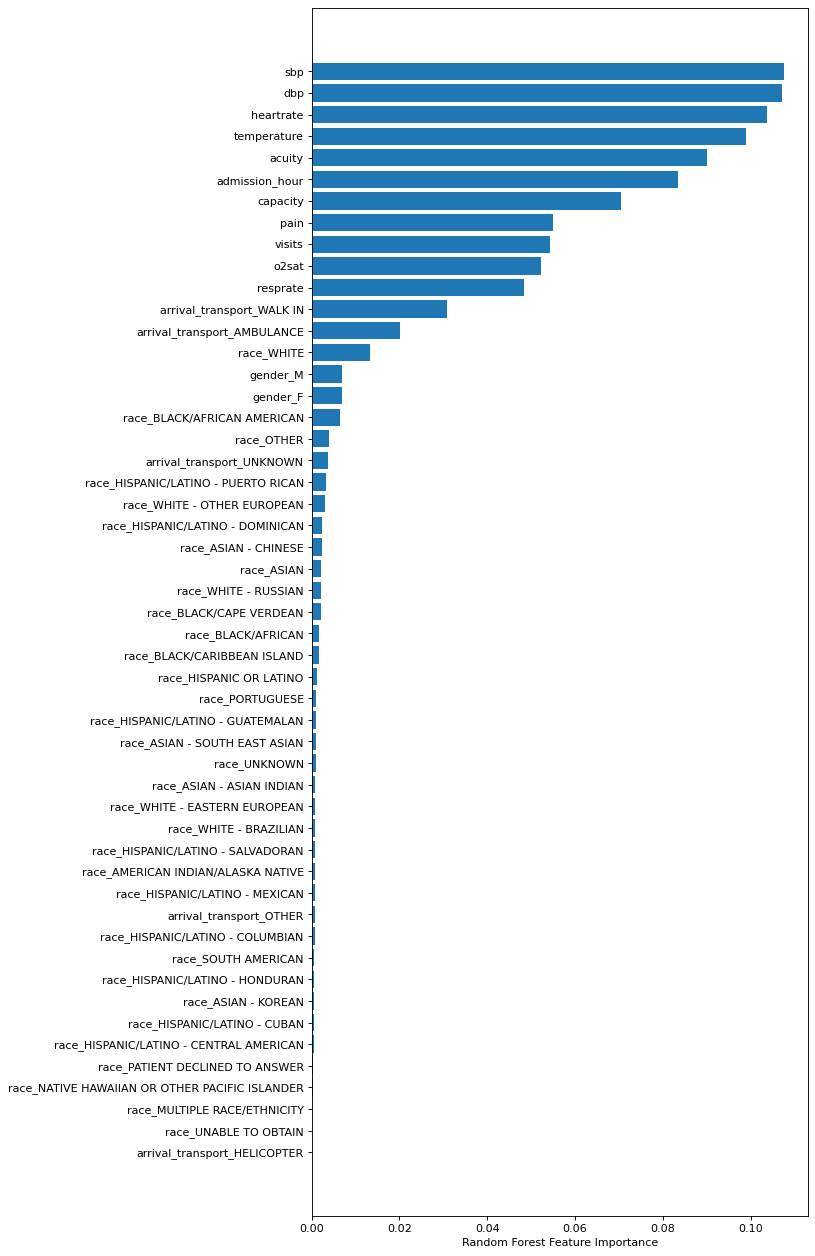

In [151]:
from matplotlib.pyplot import figure

figure(figsize=(8, 20), dpi=80)

sorted_idx = ran.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], ran.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")